In [3]:
# leave this stuff alone (but run it)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from analysisTools import *
import pickle

In [4]:
cd ~/Desktop/sara_2023-03-07/

/Users/iwoods/Desktop/sara_2023-03-07


In [5]:
# load the raw data ... takes awhile if lots of files ... so maybe skip to load binned data below
# d = loadData('xy2')
# print(np.shape(d)) # rows, columns. 
# Rows should be time (s) x 30 (framerate)
# Columns should be 2 x (# of individuals) + 1. 

Loading .npy files
(2736000, 25)


In [19]:
# OR instead of loading raw data, load the binned distance data (from npy2csv)
individuals = [str(i) for i in np.arange(1,13)]
distances = pd.read_csv('distances_230310-132439_60.csv', names=individuals, header=None)
print(np.shape(distances)) # rows, columns
# columns should be # of individuals
# rows should be time bins . . . 
distances.head(5) # look at a bit of the data

(4433, 12)


,1,2,3,4,5,6,7,8,9,10,11,12
0,986.85,454.57,860.92,587.88,489.41,599.16,352.82,947.58,266.34,388.82,466.98,524.15
1,544.16,219.85,414.96,300.13,223.80,68.90,653.97,499.07,612.05,372.21,199.76,595.78
2,640.57,282.46,328.89,331.91,104.02,69.27,508.38,595.90,546.32,305.89,227.99,628.61
3,527.60,268.36,274.06,545.82,174.55,144.38,495.04,665.57,163.95,234.81,221.30,679.74
4,289.25,344.95,183.56,439.33,108.58,173.40,635.42,592.75,193.28,165.63,495.73,515.74


In [70]:
# load the time stamps for the binned data
cols = ['dates','times']
timestamps = pd.read_csv('timeStamps_230310-132439_60.csv',delimiter=' ', names=cols, header=None)
dates = timestamps.dates.values
times = timestamps.times.values

timeaxis = [np.datetime64(dates[i] + 'T' + times[i]) for i, time in enumerate(times)]
print(timeaxis[:5])
timestamps.head(3)

# https://numpy.org/doc/stable/reference/arrays.datetime.html may be useful for dates and times in numpy

[numpy.datetime64('2023-03-07T11:30:36'), numpy.datetime64('2023-03-07T11:31:36'), numpy.datetime64('2023-03-07T11:32:36'), numpy.datetime64('2023-03-07T11:33:36'), numpy.datetime64('2023-03-07T11:34:36')]


,dates,times
0,2023-03-07,11:30:36
1,2023-03-07,11:31:36
2,2023-03-07,11:32:36


## Quality control

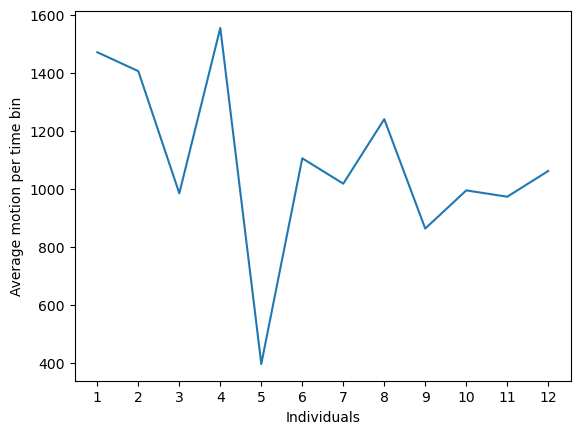

In [75]:
# show overall motion for individuals over experiment ... any motion less?
individualsVmotion = distances.mean()
plt.plot(individualsVmotion)
plt.xlabel('Individuals')
plt.ylabel('Average motion per time bin')
plt.show()

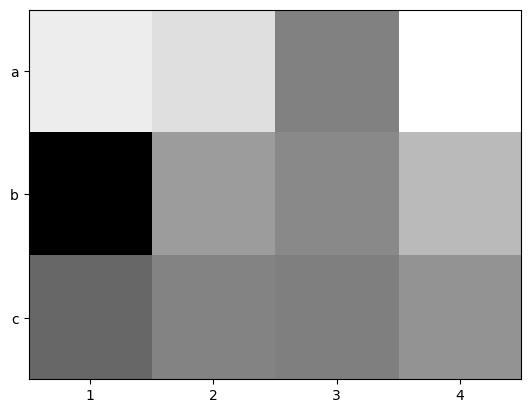

[[6518673.58 6229952.22 4364557.15 6890182.78]
 [1759115.   4899093.37 4511712.32 5497157.06]
 [3826347.19 4409209.19 4312692.7  4705667.06]]


In [35]:
# another look at overall activity in plate ... are there any dead individuals that should be omitted?
# is the difference in illumination across the plate causing big problems?
totalActivity = distances.sum().values
plateView = np.reshape(totalActivity,(3,4))
plt.imshow(plateView, interpolation='nearest', cmap = 'gray')
columns = np.array([1,2,3,4])
rows = ['a','b','c']
plt.xticks(columns-1, columns)
plt.yticks([0,1,2],rows) # or other way?
plt.show()

print(plateView)

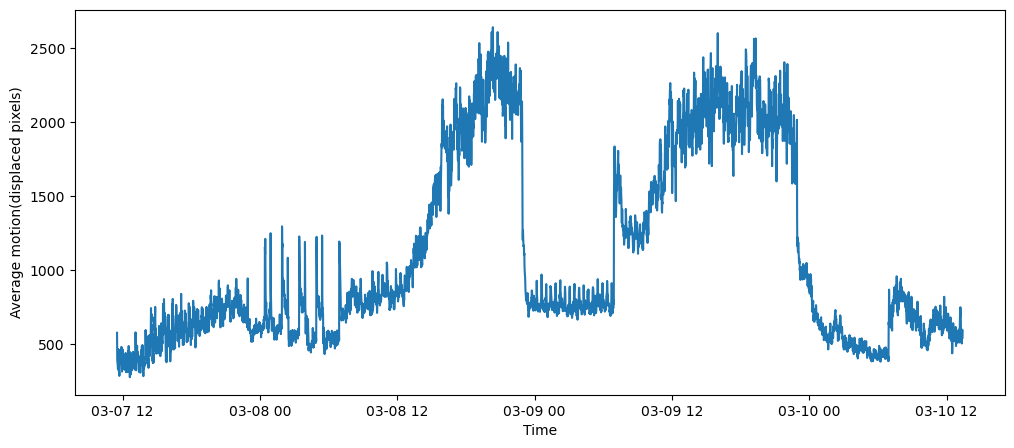

In [74]:
# show overall motion for individuals over experiment ... any motionless?
timeVmotion = distances.mean(axis=1)
f,a = plt.subplots(figsize=(12,5))
plt.plot(timeaxis, timeVmotion)
plt.xlabel('Time')
plt.ylabel('Average motion(displaced pixels)')
plt.show()

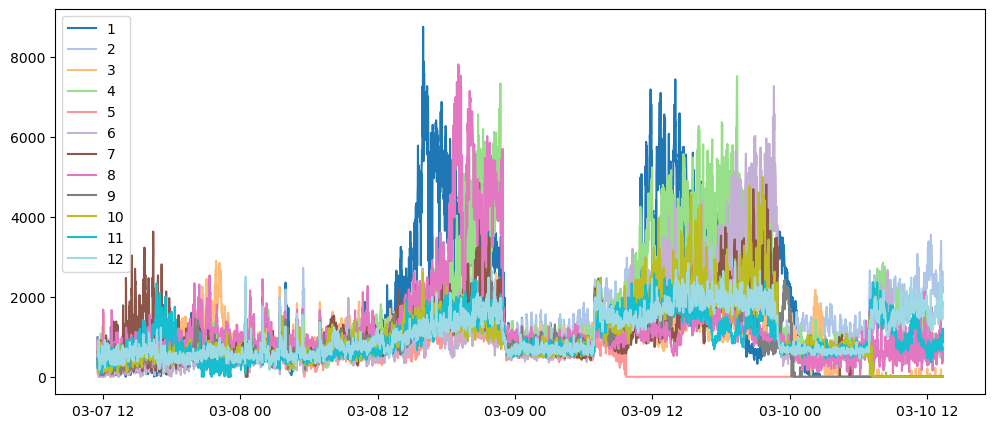

In [76]:
# plot activity of each individual in a different color
import matplotlib
colormap = 'tab20'
cmap = matplotlib.cm.get_cmap(colormap)
cols = [cmap(x) for x in np.linspace(0,1,len(individuals))]

f,a = plt.subplots(figsize = (12,5))
for i,individual in enumerate(individuals):
    plt.plot(timeaxis, distances[individual].values, color = cols[i] , label = individual)
plt.legend()
plt.show()

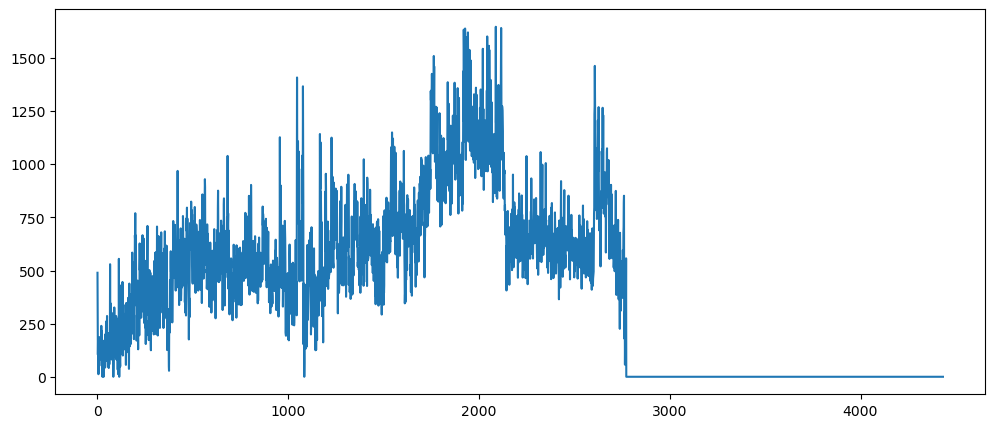

In [68]:
# plot a particular individual
individual = 5
f,a = plt.subplots(figsize = (12,5))
plt.plot(distances[str(individual)].values)
plt.show()

## Run the analysis

In [46]:
# bin the data ... but it's already binned in minutes so maybe not
# binSizeInSeconds = 5
# numBins = int(math.floor(totalSecs / binSizeInSeconds)) - 1
# binStarts = [int(b * binSizeInSeconds * frameRate) for b in range(numBins)]
# binnedTime = np.array([timeVec[b] for b in binStarts])
# binnedData = np.zeros([len(binStarts),np.shape(d)[1]])
# for b in range(len(binStarts)-1): # last bin omitted b/c incomplete
#     binnedData[b,:] = np.sum(d[binStarts[b]:binStarts[b+1],:],axis=0)
# print(np.shape(binnedData))

(132, 96)
